In [1]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import healpy as hp
import healpy.projector as pro
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
from   scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle
from   pylab import arange, show, cm
import seaborn as sb

%matplotlib inline


colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


fisColor = colors[0]
irasColor = colors[1]
ircColor = colors[2]
hfiColor = colors[3]
wiseColor = colors[4]

fontsize=20




In [2]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)
planck_bb.columns



Index([u'$T$', u'$B$', u'$I_{dust}(545)$', u'$R_{PR1}$', u'$\tau_{353,PR1}$',
       u'$U$'],
      dtype='object')

%%latex
\section{Make band pass plot}

%%latex
\subsection{Load in the Filters}
Filters taken from \cite{doi15}

In [3]:
filters_dir = "/work1/users/aaronb/Databrary/Filters/"


iras12  = pd.read_csv(filters_dir+"filter_iras12", 
                      names= ['Wavelength','IRAS12'],
                      header=0)
wise12  = pd.read_csv(filters_dir+"filter_wise12", 
                      names= ['Wavelength','WISE12'],
                      header=0)
akari9  = pd.read_csv(filters_dir+"filter_akari9", 
                      names= ['Wavelength','AKARI9'],
                      header=0)
akari18 = pd.read_csv(filters_dir+"filter_akari18", 
                      names= ['Wavelength','AKARI18'],
                      header=0)
iras25  = pd.read_csv(filters_dir+"filter_iras25", 
                      names= ['Wavelength','IRAS25'],
                      header=0)
iras60  = pd.read_csv(filters_dir+"filter_iras60", 
                      names= ['Wavelength','IRAS60'],
                      header=0)

akari65  = pd.read_csv(filters_dir+"filter_akari65", 
                      names= ['Wavelength','AKARI65'],
                      header=0)

akari90  = pd.read_csv(filters_dir+"filter_akari90", 
                      names= ['Wavelength','AKARI90'],
                      header=0)

iras100  = pd.read_csv(filters_dir+"filter_iras100", 
                      names= ['Wavelength','IRAS100'],
                      header=0)

akari140  = pd.read_csv(filters_dir+"filter_akari140", 
                      names= ['Wavelength','AKARI140'],
                      header=0)

akari160  = pd.read_csv(filters_dir+"filter_akari160", 
                      names= ['Wavelength','AKARI160'],
                      header=0)

planck857= pd.read_csv(filters_dir+"filter_planck857", 
                      names= ['Wavelength','PLANCK857'],
                      header=0)

planck545= pd.read_csv(filters_dir+"filter_planck545", 
                      names= ['Wavelength','PLANCK545'],
                      header=0)



%%latex
\subsection{MIR Data}

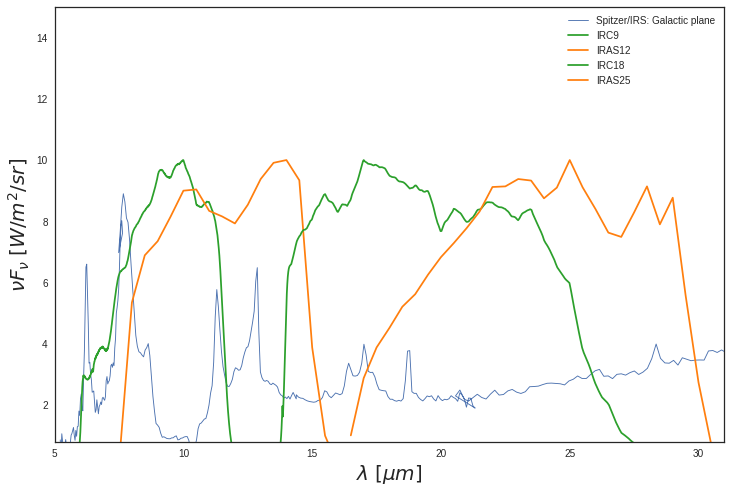

In [4]:
plt.figure(figsize = (12,8))
onakaMIR = pd.read_table('../Data/cirrus2 9_35_52  2005_02_26.txt', 
                      names= ['Wavelength','Spitzer/IRS'],
                      header=0)
onakaMIR['Spitzer/IRS']*u.Jy
onakaMIR['Spitzer/IRS'] *= c.c/onakaMIR['Wavelength']*u.um.to(u.m)
#print onakaMIR['MIR'][1]
#onakaMIR['Wavelength'] *= u.micron
#onakaMIR['MIR'].values.to(u.Joule)
with sb.axes_style("white"):
    plt.plot(onakaMIR['Wavelength'],
             onakaMIR['Spitzer/IRS'],
             label= 'Spitzer/IRS: Galactic plane', linewidth=0.9)
    plt.ylabel('$\\nu{}F_{\\nu}$ $[W/m^{2}/sr]$', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(akari9.Wavelength,akari9.AKARI9*10,label="IRC9", color=ircColor)
    plt.plot(iras12.Wavelength,iras12.IRAS12*10,label="IRAS12", color=irasColor)
    plt.plot(akari18.Wavelength,akari18.AKARI18*10,label="IRC18", color=ircColor)
    plt.plot(iras25.Wavelength,iras25.IRAS25*10,label="IRAS25", color=irasColor)
    plt.xlim(5,31)
    plt.ylim(0.8,15)
    plt.legend()
    #plt.vlines(6.2,7,10,linestyles = 'dashed')
    #plt.vlines(7.7,9,10,linestyles = 'dashed')
    #plt.vlines(11.2,6,10,linestyles = 'dashed')
    
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_MIR.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)


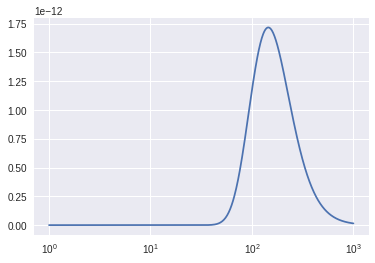

In [7]:
from astropy.modeling.blackbody import blackbody_lambda
bb_wave = np.linspace(1,1000,1000)*u.micron
bb = blackbody_lambda(bb_wave, 20*u.K)
plt.plot(bb_wave, bb.value*bb.value.max())
plt.xscale('log')

%%latex
\subsection{Modified black body: Emissivity 'correction'}

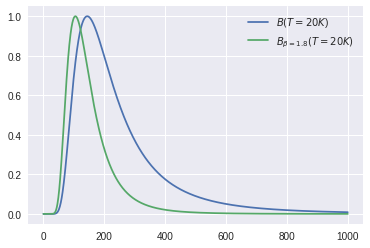

In [8]:
ref_wave = 550*u.micron # Arbitrary 'pivot' wavelength 
beta = 1.8 # Emissivity index
bb_corr = (ref_wave/bb_wave)**beta

mbb = bb *bb_corr


plt.plot(bb_wave, bb.value/bb.value.max(), label = '$B(T=20K$)')
plt.plot(bb_wave, mbb.value/mbb.value.max(), label = '$B_{\\beta{}=1.8}(T=20K)$')
#plt.xscale('log')
plt.legend()


mbb = pd.DataFrame(
    np.array([bb_wave,mbb]).T,
    columns=['Wavelength','MBB'])

#mbb.MBB/=mbb.MBB.max()

mbb.MBB /= mbb.Wavelength


#mbb.MBB*=scale_factor

### Import DustEM example SEDs

In [9]:
ex_SED_file = "../Data/SED_example_DustEM.txt"
#ex_SED = 
ex_SED = pd.DataFrame(
    np.genfromtxt(ex_SED_file),
    columns = ['Wavelength','PAH0','PAH1','acB0','acB1','aSil', 'Total'])
ex_SED.describe()


ex_SED_norm = ex_SED.copy()
ex_SED_norm[['PAH0','PAH1','acB0','acB1','aSil', 'Total']] /= ex_SED_norm['Total'].max()


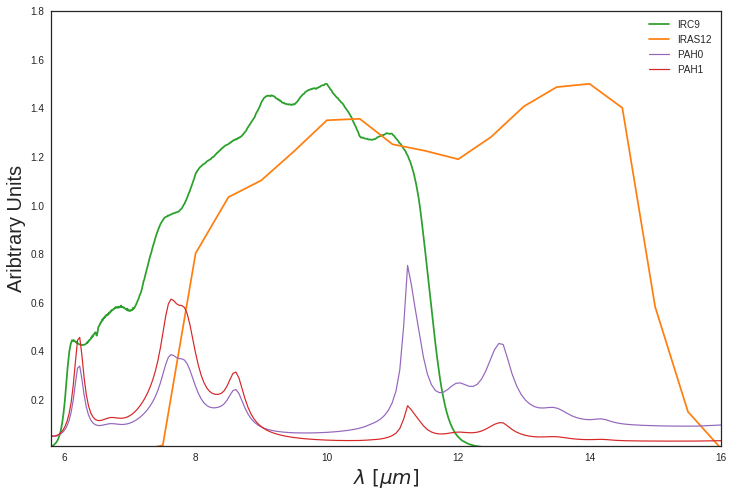

In [15]:
plt.figure(figsize = (12,8))

with sb.axes_style("white"):
    plt.ylabel('Aribtrary Units', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(akari9.Wavelength,akari9.AKARI9*1.5,label="IRC9", color=ircColor)
    plt.plot(iras12.Wavelength,iras12.IRAS12*1.5,label="IRAS12", color=irasColor)
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH0'],linewidth=1.2, color =  colors[-6])
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH1'],linewidth=1.2, color =  colors[-7])

    plt.legend()
    plt.ylim((0.01,1.8))
    plt.xlim((5.8,16))
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_PAH.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


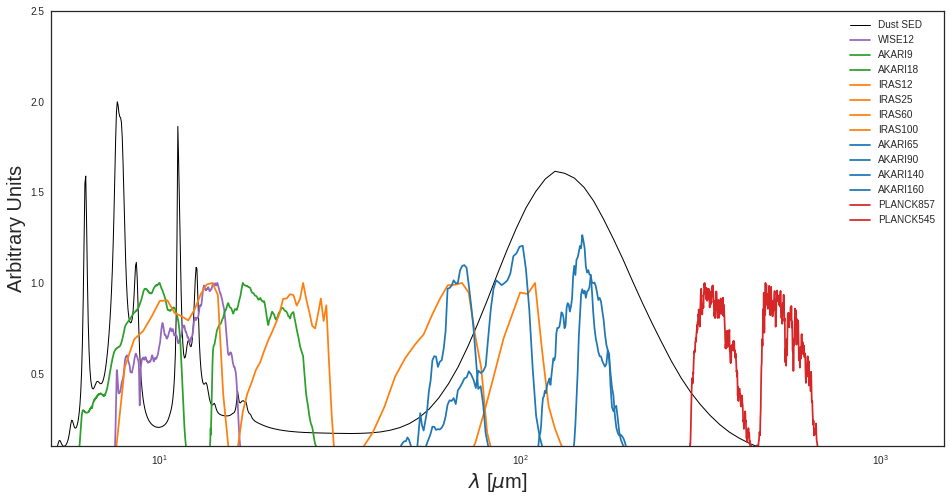

In [14]:
# Set ranges:
xmax = 1.5e3
xmin = 5
ymin = 0.1
ymax = 2.5
logx = True

#colors = sb.color_palette("tab")


with sb.axes_style("white"):

    fig = plt.figure(figsize = (16,8))
    #gs1 = gridspec.GridSpec(2, 1)
    #gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    ax1 = fig.add_subplot(111)
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     ex_SED_norm['Total']*2, 
                     #linestyle = 'dashed',
                     color = 'black',
                     linewidth = 1,
                     label = 'Dust SED')
    
    # Plot the filters
    #wise12_norm['WISE12'] = (wise12['WISE12'] - wise12['WISE12'].mean()) / (wise12['WISE12'].max() - wise12['WISE12'].min())
    wise12_norm = wise12
    wise12_norm['WISE12'] = (wise12['WISE12']  / wise12['WISE12'].max())

    wise12_norm.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = wiseColor)
    
    akari9.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
    akari18.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
   
    iras12.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras25.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras60.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras100.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    
    akari65.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari90.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari140.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari160.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    
    planck857.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color=hfiColor)
    planck545.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax),
                   ylim=(ymin,ymax),
                   ax=ax1, color = hfiColor)
    
    
    # Plot the MIR spectrum
    
    #onakaMIR.plot(x='Wavelength',y='MIR',xlim=(xmin,xmax),ylim = (ymin, ymax), ax = ax1)
    
    # Plot FIR modified blackbody
    
#     mbb.plot(x='Wavelength',
#              xlim=(xmin,xmax),
#              ylim = (ymin, ymax), 
#              ax = ax1)
    
    plt.xlabel('$\lambda$ [$\mu$m]', fontsize=fontsize)
    plt.ylabel("Arbitrary Units", fontsize=fontsize)
    plt.legend()
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_full.pdf')
    

%%latex
\section{PAH Ionization Fraction Example}

In [ ]:
filters = pd.DataFrame.from_csv("/work1/users/aaronb/Codebrary/Python/filters_PAH.dat", header=0)

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


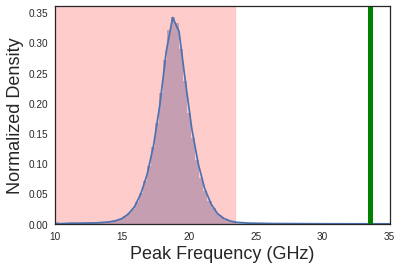

In [28]:
import matplotlib
with sb.axes_style("white"):
    fontsize = 18
    
    ame_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits')
    plt.figure()
    nuhist = sb.distplot(ame_freq_allsky[ame_freq_allsky!=hp.UNSEEN],
                rug=False, bins = 200 )

    nuhist.set_xlim(10,35)
    nuhist.set_xlabel("Peak Frequency (GHz)", fontsize=fontsize)
    nuhist.set_ylabel("Normalized Density", fontsize=fontsize)
    #nuhist.set_title("Per-pixel AME $\\nu_{peak}$ not well constrained", fontsize=fontsize)
    nuhist.axvline(x=33.5, ymin=0, ymax = 1, linewidth=5, color='g')

    nuhist.axvspan(8, 23.5, alpha=0.2, color='red')
    plt.savefig("../Plots/ch_intro/AME_commander_freqdist.pdf")


In [35]:
cmap = cm.rainbow
cmap.set_under('w')

In [36]:
PCCS_crossmatrix = planck_mw[['$I_{dust}(545)$','$T$','$B$']].join(planck_bb[['$I_{dust}(545)$','$T$','$B$']]).corr(method='spearman')

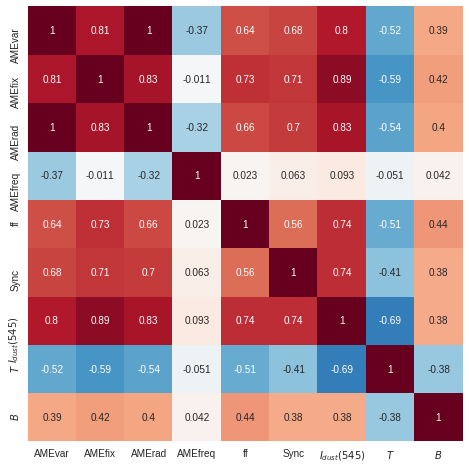

In [41]:
plt.figure(figsize=(8,8))
sb.heatmap(PCCS_crossmatrix,
          square=True,
          annot=True,
           cbar=False
          )
plt.savefig('../Plots/ch_datasources/PCCS_corrmatrix.pdf')

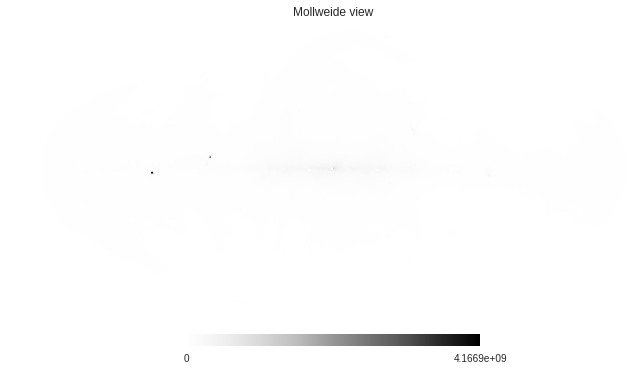

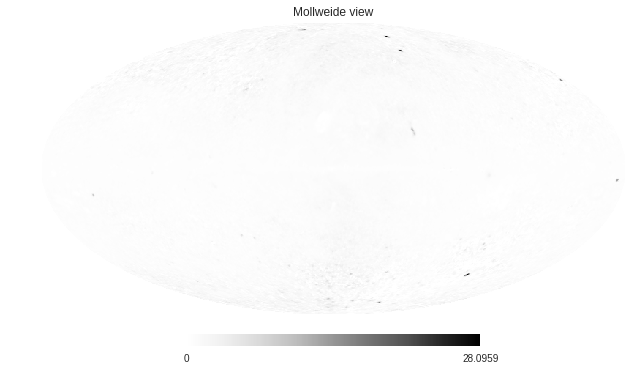

In [16]:
sync          = hp.mollview(planck_mw.Sync, nest=True, return_projected_map=True)
ame_rad_ratio = hp.mollview(planck_mw['AME']/planck_bb['$I_{dust}(545)$'], nest =True, return_projected_map=True)

AttributeError: 'AxesImage' object has no attribute 'plot'

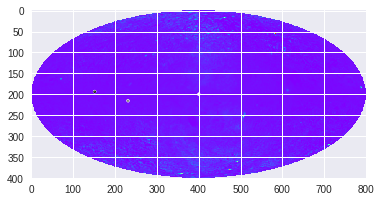

In [24]:
f = plt.imshow(ame_rad_ratio, cmap=cmap)


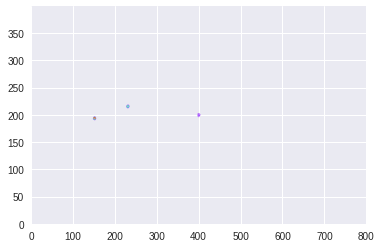

In [27]:
plt.contour(sync, cmap=cmap, alpha=0.5)

In [ ]:
sb.axes_style("white"):
    
    

    
hp.mollview(planck_mw['AME']/planck_bb['$I_{dust}(545)$'], 
               norm='hist', 
                nest=True, 
                #min=1.5, max = 2.0, 
                cmap=cmap,
                title = '${I_{AME}}_{var}(28.4 GHz) / I_{dust}(545 GHz)$')
plt.savefig('../Plots/ch_datasources/R_PCAMEtoPCRad.pdf')


hp.mollview(AMEvar_freq, 
            #norm='hist', 
            nest=True, 
            min=12, 
            max = 40, 
            cmap=cmap,
           title="PCAME Peak Frequencies",
           unit='GHz')

plt.savefig('../Plots/ch_datasources/PCAME_var_freq.pdf')

In [ ]:
rand_seed = 42

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMErad'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_rad.pdf')

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEvar'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_var.pdf')

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_fix.pdf')


sb.jointplot(ancillframe['$H_{a}$'].divide(ancillframe['$N_{H}$']).sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)